# Отток клиентов из банка

<a id=0></a>
[Содержание](#0)

[1. Описание проекта](#1)

[2. Анализ данных](#2)

[3. Подготовка данных](#3)

[4. Исследование задачи](#4)

[5. Борьба с дисбаллансом](#5)

[6. Тестирование модели](#6)

[7. Общий вывод](#7)

<a id=1></a>
## 1. Описание проекта

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно.

Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет.

**Цель проекта:**

Построить модель с предельно большим значением *F1*-меры.

Довести метрику до 0.59.

Проверить *F1*-меру на тестовой выборке.

Дополнительно измерить *AUC-ROC*, сравнить её значение с *F1*-мерой.

**Данные:**

Предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

`/datasets/Churn.csv` ([ссылка](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling))

Признаки:
- `RowNumber` — индекс строки в данных
- `CustomerId` — уникальный идентификатор клиента
- `Surname` — фамилия
- `CreditScore` — кредитный рейтинг
- `Geography` — страна проживания
- `Gender` — пол
- `Age` — возраст
- `Tenure` — сколько лет человек является клиентом банка
- `Balance` — баланс на счёте
- `NumOfProducts` — количество продуктов банка, используемых клиентом
- `HasCrCard` — наличие кредитной карты
- `IsActiveMember` — активность клиента
- `EstimatedSalary` — предполагаемая зарплата

Целевой признак:
- `Exited` — факт ухода клиента

<a id=2></a>
[Содержание](#0)
## 2. Анализ данных

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score, roc_curve
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import random
import numpy as np
import warnings
warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None

In [2]:
try:
    df = pd.read_csv('/datasets/Churn.csv')
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/Churn.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [4]:
df.head(5)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


<a id=3></a>
[Содержание](#0)
## 3. Подготовка данных

Удалим колонки, которые не несут полезной информации для обучения модели

In [5]:
df = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis = 1)

В данных есть пропуски в столбце: `Tenure`

Посмотрим распределение данных в столбце

In [6]:
df['Tenure'].value_counts()

1.0     952
2.0     950
8.0     933
3.0     928
5.0     927
7.0     925
4.0     885
9.0     882
6.0     881
10.0    446
0.0     382
Name: Tenure, dtype: int64

Рассмотрим варианты работы с пропусками:

1. Распределение по годам использования банка практически ровное, если заменить 909 пропусков медианой, то мы увеличим в 2 раза значение для 5 лет, это некорректно.

*df['Tenure'] = df['Tenure'].fillna(round(df['Tenure'].mean()))*

2. Можно сделать заполнение пропусков случайными числами, тогда мы снизим влияние на наше распределение.

3. Так как значений в этом признаке ограниченное количество, можно сделать его категориальным признаком. Пропуски можно считать как за отдельную категорию (заполнить значением -1). Затем заменить тип данных `Tenure` на object и применить технику OHE.

4. Заполнить '0', считая, что это новые клиенты.

Заполним пропуски случайными значениями в интервале от 0 до 10

In [7]:
def fill_rnd(val):
    if np.isnan(val):
        return random.randint(0, 10)
    else:
        return val

df['Tenure'] = df['Tenure'].apply(fill_rnd)
df['Tenure'].value_counts()

1.0     1039
2.0     1025
7.0     1017
8.0     1011
5.0     1005
3.0     1001
4.0      967
6.0      965
9.0      963
10.0     534
0.0      473
Name: Tenure, dtype: int64

In [8]:
df.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,4.998900,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.924783,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,8.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


Типы данных в столбцах:

Категориальный: `Geography`, `Gender`, `HasCrCard`, `IsActiveMember`, `Exited`

Количественный: `CreditScore`, `Age`, `Tenure`, `Balance`, `NumOfProducts`, `EstimatedSalary`

Разобъем данные в соотношениях 60/20/20:

In [9]:
df_x = df.drop(columns = ['Exited']).copy()
df_y = df['Exited']

# Выделим 60% под тренировочные данные и 40% под валидационные и тестовые
x_train, x_rest, y_train, y_rest = train_test_split(df_x, df_y, train_size = 0.6,
                                                    random_state = 22122022, stratify = df_y)

# Разделим данные по 50% под валидационные и тестовые
x_valid, x_test, y_valid, y_test = train_test_split(x_rest, y_rest, test_size = 0.5,
                                                    random_state = 22122022, stratify = y_rest)

print('Размер тренерующей  выборки:', x_train.shape)
print('Размер валидационной выборки:', x_valid.shape)
print('Размер тестовой     выборки:', x_test.shape)

Размер тренерующей  выборки: (6000, 10)
Размер валидационной выборки: (2000, 10)
Размер тестовой     выборки: (2000, 10)


Кодируем данные после разбиения, чтобы не было "утечки данных".

Подробнее по [ссылке](https://datascience.stackexchange.com/questions/108663/why-label-encoding-before-split-is-data-leakage)

In [10]:
x_train = pd.get_dummies(x_train, drop_first = True)
x_valid = pd.get_dummies(x_valid, drop_first = True)
x_test  = pd.get_dummies(x_test,  drop_first = True)

x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6000 entries, 3770 to 5543
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CreditScore        6000 non-null   int64  
 1   Age                6000 non-null   int64  
 2   Tenure             6000 non-null   float64
 3   Balance            6000 non-null   float64
 4   NumOfProducts      6000 non-null   int64  
 5   HasCrCard          6000 non-null   int64  
 6   IsActiveMember     6000 non-null   int64  
 7   EstimatedSalary    6000 non-null   float64
 8   Geography_Germany  6000 non-null   uint8  
 9   Geography_Spain    6000 non-null   uint8  
 10  Gender_Male        6000 non-null   uint8  
dtypes: float64(3), int64(5), uint8(3)
memory usage: 439.5 KB


**Вывод:**

Удалены не влияющие на обучение модели данные.

Пропуски заполнены.

Данные разделены на тренировочную, валидационную и тестовую части в пропорциях 60/20/20.

Обучение пройдет на данных: x_train -> y_train

Валидация модели на данных: x_valid -> y_valid

Лучшая модель по результатам валидации будет проверена на тестовых данных: x_test -> y_test


<a id=4></a>
[Содержание](#0)
## 4. Исследование задачи

Будем использовать следующие модели:

- Логистическая регрессия

- Случайный лес

Для линейных моделей улучшает результат масштабирование численных признаков

In [11]:
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

scaler = StandardScaler()
scaler.fit(x_train[numeric])

StandardScaler()

Посмотрим, какой существует дисбаланс классов

In [12]:
x_train[numeric] = scaler.transform(x_train[numeric])
x_valid[numeric] = scaler.transform(x_valid[numeric])
x_test[numeric]  = scaler.transform(x_test[numeric])

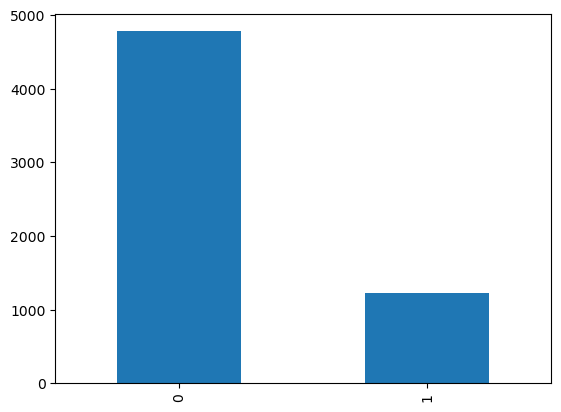

In [14]:
y_train.value_counts().plot(kind = 'bar', label = 'train')
plt.show()

Соотношение классов 1:4. Изучим модели без исправление баланса.

Для каждого алгоритма подберем лучшие гиперпарамерты поиском по сетке по метрике f1.


### Cлучайный лес

Проведем исследование на разное количество деревьев с шагом 10

In [100]:
best_est = 0
best_f1 = 0

for est in range(1, 300, 10):
    model = RandomForestClassifier(random_state = 22122022, n_estimators = est)
    model.fit(x_train, y_train)
    valid_predictions = model.predict(x_valid)
    f1 = f1_score(y_valid, valid_predictions)
#    print('Количество деревьев:', est,'F1:', f1)
    
    if f1 > best_f1:
        best_est = est
        best_f1 = f1

print('Лучшее количество деревьев:', best_est, 'Лучшая F1:', best_f1)

Лучшее количество деревьев: 61 Лучшая F1: 0.5987841945288753


Лучший результат лежит в диапазоне 50-70, рассмотрим его более детально с шагом 1

In [16]:
best_est = 0
best_f1 = 0

for est in range(50, 70):
    model = RandomForestClassifier(random_state = 22122022, n_estimators = est)
    model.fit(x_train, y_train)
    valid_predictions = model.predict(x_valid)
    f1 = f1_score(y_valid, valid_predictions)
#    print('Количество деревьев:', est,'F1:', f1)
    
    if f1 > best_f1:
        best_est = est
        best_f1 = f1

print('Лучшее количество деревьев:', best_est, 'Лучшая F1:', best_f1)

Лучшее количество деревьев: 67 Лучшая F1: 0.5981873111782477


**Вывод:**

При 67 деревьях F1 достигает 0.5981

### Логистическая регрессия

In [17]:
best_max_iter = 0
best_f1 = 0

for max_iter in range(1, 50):
    model = LogisticRegression(random_state = 22122022, max_iter = max_iter)
    model.fit(x_train, y_train)
    valid_predictions = model.predict(x_valid)
    f1 = f1_score(y_valid, valid_predictions)
#    print('Количество деревьев:', max_iter,'F1:', f1)
    
    if f1 > best_f1:
        best_max_iter = max_iter
        best_f1 = f1

print('Лучшее количество итераций:', best_max_iter, 'Лучшая F1:', best_f1)

Лучшее количество итераций: 6 Лучшая F1: 0.3623445825932505


**Вывод:**

Результаты довольно низкие, F1 = 0.3623 при 6 итерациях.

Возможно Precision или Recall низкие и близки к 0.

Проведем оценку Accuracy, Precision и Recall, также покажем F-метрику.

In [18]:
%%time

model_RFC = RandomForestClassifier(random_state = 22122022, n_estimators = 65)
model_RFC.fit(x_train, y_train)
valid_predictions_RFC = model_RFC.predict(x_valid)
print('- Случайный лес -')
print('Accuracy', accuracy_score(y_valid, valid_predictions_RFC))
print('Precision', precision_score(y_valid, valid_predictions_RFC))
print('Recall', recall_score(y_valid, valid_predictions_RFC))
print('F1', f1_score(y_valid, valid_predictions_RFC))

- Случайный лес -
Accuracy 0.8665
Precision 0.7777777777777778
Recall 0.48157248157248156
F1 0.5948406676783003
CPU times: user 334 ms, sys: 4.75 ms, total: 338 ms
Wall time: 338 ms


In [19]:
%%time

model_LR = LogisticRegression(random_state = 22122022, max_iter = 6)
model_LR.fit(x_train, y_train)
valid_predictions_LR = model_LR.predict(x_valid)
print('- Логистическая регрессия -')
print('Accuracy', accuracy_score(y_valid, valid_predictions_LR))
print('Precision', precision_score(y_valid, valid_predictions_LR))
print('Recall', recall_score(y_valid, valid_predictions_LR))
print('F1', f1_score(y_valid, valid_predictions_LR))

- Логистическая регрессия -
Accuracy 0.8205
Precision 0.6538461538461539
Recall 0.25061425061425063
F1 0.3623445825932505
CPU times: user 76.7 ms, sys: 63.6 ms, total: 140 ms
Wall time: 29.5 ms


Проведем построение ROC-кривой для каждой модели и выведем показатель AUC-ROC.

AUC-ROC RandomForestClassifier 0.85282277655159
AUC-ROC LogisticRegression 0.7687996162572434


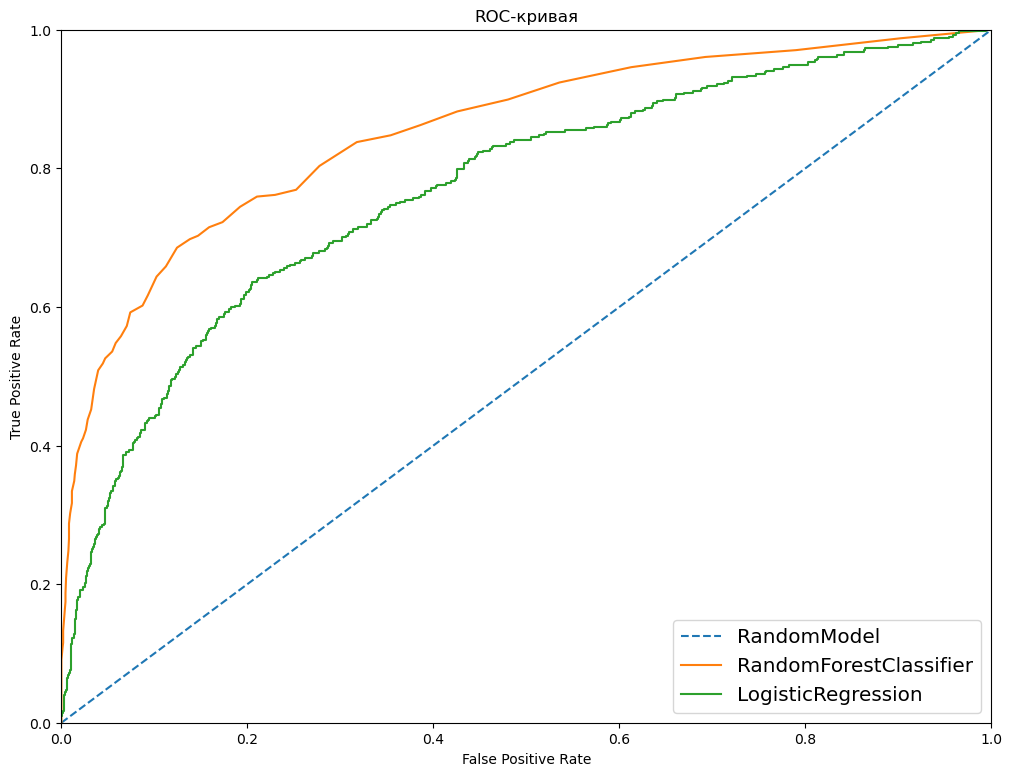

In [20]:
plt.figure(figsize=[12,9])
plt.plot([0, 1], [0, 1], linestyle = '--', label = 'RandomModel')

probabilities_valid = model_RFC.predict_proba(x_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(y_valid, probabilities_one_valid)
auc_roc = roc_auc_score(y_valid, probabilities_one_valid)
print('AUC-ROC RandomForestClassifier', auc_roc)
plt.plot(fpr, tpr, label = 'RandomForestClassifier')

probabilities_valid = model_LR.predict_proba(x_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(y_valid, probabilities_one_valid)
auc_roc = roc_auc_score(y_valid, probabilities_one_valid)
print('AUC-ROC LogisticRegression', auc_roc)
plt.plot(fpr, tpr, label = 'LogisticRegression')

plt.xlim([0, 1])
plt.ylim([0, 1])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend(loc = 'lower right', fontsize = 'x-large')

plt.title('ROC-кривая')
plt.show()

**Вывод:**

По полученным результатам можно заменить, что метрика F1 и AUC-ROC лучшая на случаном лесе.

В данных сущестует дисбаланс классов в отношении 1:4.

Возможно он влияет на качество изучаемых моделей.

Все модели имеют Recall ниже, чем Percision, из-за перекоса данных, что влияет на F1.

<a id=5></a>
[Содержание](#0)
## 5. Борьба с дисбалансом

Для борьбы с дисбалансом выполним сравнение моделей:

- С взвешенными классами
- С уменьшенной выборкой
- С увеличенной выборкой

Изучим возможности моделей по взвешиванию классов.

In [21]:
%%time

model_RFC = RandomForestClassifier(random_state = 22122022, n_estimators = 65, class_weight = 'balanced')
model_RFC.fit(x_train, y_train)
valid_predictions_RFC = model_RFC.predict(x_valid)
print('- Случайный лес -')
print('Accuracy', accuracy_score(y_valid, valid_predictions_RFC))
print('Precision', precision_score(y_valid, valid_predictions_RFC))
print('Recall', recall_score(y_valid, valid_predictions_RFC))
print('F1', f1_score(y_valid, valid_predictions_RFC))

- Случайный лес -
Accuracy 0.8645
Precision 0.772
Recall 0.4742014742014742
F1 0.5875190258751902
CPU times: user 323 ms, sys: 6.77 ms, total: 330 ms
Wall time: 329 ms


In [22]:
%%time

model_LR = LogisticRegression(random_state = 22122022, max_iter = 6, class_weight = 'balanced')
model_LR.fit(x_train, y_train)
valid_predictions_LR = model_LR.predict(x_valid)
print('- Логистическая регрессия -')
print('Accuracy', accuracy_score(y_valid, valid_predictions_LR))
print('Precision', precision_score(y_valid, valid_predictions_LR))
print('Recall', recall_score(y_valid, valid_predictions_LR))
print('F1', f1_score(y_valid, valid_predictions_LR))

- Логистическая регрессия -
Accuracy 0.7205
Precision 0.39473684210526316
Recall 0.7002457002457002
F1 0.5048715677590788
CPU times: user 103 ms, sys: 56.6 ms, total: 159 ms
Wall time: 32.4 ms


F-мера упала у случайного леса, но выросла у логистической регресии.

Исследуем способ уменьшения значений класса 0.

In [23]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac = fraction, random_state = 22122022)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac = fraction, random_state = 22122022)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state = 22122022)
    
    return features_downsampled, target_downsampled


x_downsampled, y_downsampled = downsample(x_train, y_train, 0.25)

print(y_downsampled.value_counts())

1    1222
0    1194
Name: Exited, dtype: int64


In [24]:
%%time

model_RFC = RandomForestClassifier(random_state = 22122022, n_estimators = 65)
model_RFC.fit(x_downsampled, y_downsampled)
valid_predictions_RFC = model_RFC.predict(x_valid)
print('- Случайный лес -')
print('Accuracy', accuracy_score(y_valid, valid_predictions_RFC))
print('Precision', precision_score(y_valid, valid_predictions_RFC))
print('Recall', recall_score(y_valid, valid_predictions_RFC))
print('F1', f1_score(y_valid, valid_predictions_RFC))

- Случайный лес -
Accuracy 0.783
Precision 0.4786729857819905
Recall 0.7444717444717445
F1 0.5826923076923076
CPU times: user 166 ms, sys: 4.2 ms, total: 170 ms
Wall time: 169 ms


In [25]:
%%time

model_LR = LogisticRegression(random_state = 22122022, max_iter = 6)
model_LR.fit(x_downsampled, y_downsampled)
valid_predictions_LR = model_LR.predict(x_valid)
print(' -Логистическая регрессия -')
print('Accuracy', accuracy_score(y_valid, valid_predictions_LR))
print('Precision', precision_score(y_valid, valid_predictions_LR))
print('Recall', recall_score(y_valid, valid_predictions_LR))
print('F1', f1_score(y_valid, valid_predictions_LR))

 -Логистическая регрессия -
Accuracy 0.717
Precision 0.3912448700410397
Recall 0.7027027027027027
F1 0.5026362038664324
CPU times: user 102 ms, sys: 75.4 ms, total: 177 ms
Wall time: 33 ms


Показатели случайного леса немного выросли.

Логистическая регрессия почти не изменилась.

Исследуем методы увеличения класса 1.

In [26]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state = 22122022)
    
    return features_upsampled, target_upsampled


x_upsampled, y_upsampled = upsample(x_train, y_train, 4)

print(y_upsampled.value_counts())

1    4888
0    4778
Name: Exited, dtype: int64


In [27]:
%%time

model_RFC = RandomForestClassifier(random_state = 22122022, n_estimators = 65)
model_RFC.fit(x_upsampled, y_upsampled)
valid_predictions_RFC = model_RFC.predict(x_valid)
print('- Случайный лес -')
print('Accuracy', accuracy_score(y_valid, valid_predictions_RFC))
print('Precision', precision_score(y_valid, valid_predictions_RFC))
print('Recall', recall_score(y_valid, valid_predictions_RFC))
print('F1', f1_score(y_valid, valid_predictions_RFC))

- Случайный лес -
Accuracy 0.856
Precision 0.673469387755102
Recall 0.5675675675675675
F1 0.6159999999999999
CPU times: user 478 ms, sys: 7.49 ms, total: 485 ms
Wall time: 486 ms


In [28]:
%%time

model_LR = LogisticRegression(random_state = 22122022, max_iter = 6)
model_LR.fit(x_upsampled, y_upsampled)
valid_predictions_LR = model_LR.predict(x_valid)
print('- Логистическая регрессия -')
print('Accuracy', accuracy_score(y_valid, valid_predictions_LR))
print('Precision', precision_score(y_valid, valid_predictions_LR))
print('Recall', recall_score(y_valid, valid_predictions_LR))
print('F1', f1_score(y_valid, valid_predictions_LR))

- Логистическая регрессия -
Accuracy 0.718
Precision 0.3917241379310345
Recall 0.6977886977886978
F1 0.5017667844522968
CPU times: user 133 ms, sys: 128 ms, total: 261 ms
Wall time: 41.7 ms


**Вывод:**

F-мера случайного леса с увеличенным классом 1 практически идентична F-мере дисбалансных данных.

Выведем ROC-кривую и AUC-ROC для последнего измененного баланса.

AUC-ROC RandomForestClassifier 0.8520199706640383
AUC-ROC LogisticRegression 0.7745557576066051


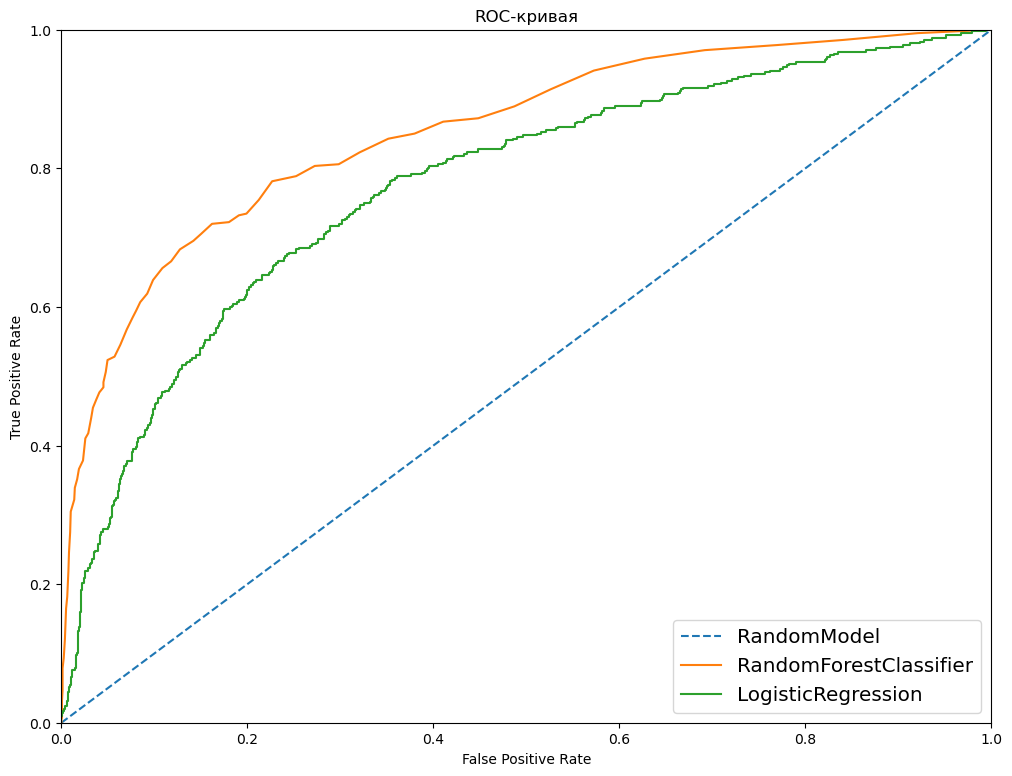

In [29]:
plt.figure(figsize=[12,9])
plt.plot([0, 1], [0, 1], linestyle = '--', label = 'RandomModel')

probabilities_valid = model_RFC.predict_proba(x_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(y_valid, probabilities_one_valid)
auc_roc = roc_auc_score(y_valid, probabilities_one_valid)
print('AUC-ROC RandomForestClassifier', auc_roc)
plt.plot(fpr, tpr, label='RandomForestClassifier')

probabilities_valid = model_LR.predict_proba(x_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(y_valid, probabilities_one_valid)
auc_roc = roc_auc_score(y_valid, probabilities_one_valid)
print('AUC-ROC LogisticRegression', auc_roc)
plt.plot(fpr, tpr, label='LogisticRegression')

plt.xlim([0,1])
plt.ylim([0,1])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend(loc = 'lower right', fontsize = 'x-large')

plt.title('ROC-кривая')
plt.show()

**Вывод:**

F-мера случайного леса с увеличенным классом 1 практически идентична F-мере дисбалансных данных.

Аналогиная картина с показателем AUC-ROC.


<a id=6></a>
[Содержание](#0)
## 6. Тестирование модели

К тестовой выборке применим модель Случайного леса. 

Исследуем гиперпараметры и улучшим F-меру модели.

Начнем с гиперпараметра n_estimators.

Проведем исследование на оптимальное количество деревьев.

In [30]:
best_est = 0
best_f1 = 0

for est in range(1, 300, 10):
    model_RFC = RandomForestClassifier(random_state = 22122022, n_estimators = est)
    model_RFC.fit(x_upsampled, y_upsampled)
    valid_predictions_RFC = model_RFC.predict(x_valid)
    f1 = f1_score(y_valid, valid_predictions_RFC)
#    print('Количество деревьев:', est,'F1:', f1)

    if f1 > best_f1:
        best_est = est
        best_f1 = f1

print('Лучшее количество деревьев:', best_est, 'Лучшая F1:', best_f1)

Лучшее количество деревьев: 131 Лучшая F1: 0.6344086021505376


Лучший результат лежит в диапазоне 120-140.

In [31]:
best_est = 0
best_f1 = 0

for est in range(120, 140):
    model_RFC = RandomForestClassifier(random_state = 22122022, n_estimators = est)
    model_RFC.fit(x_upsampled, y_upsampled)
    valid_predictions_RFC = model_RFC.predict(x_valid)
    f1 = f1_score(y_valid, valid_predictions_RFC)
#    print('Количество деревьев:', est,'F1:', f1)
    
    if f1 > best_f1:
        best_est = est
        best_f1 = f1

print('Лучшее количество деревьев:', best_est, 'Лучшая F1:', best_f1)

Лучшее количество деревьев: 134 Лучшая F1: 0.6369770580296896


F1 достигла 0.6369 при 134 деревьях

Изменим гиперпараметр min_samples_split.

In [32]:
best_min_ssplit = 0
best_f1 = 0

for samples_split in range(1, 11):
    model_RFC = RandomForestClassifier(random_state = 22122022, n_estimators = 134,
                                       min_samples_split = samples_split / 10)
    model_RFC.fit(x_upsampled, y_upsampled)
    valid_predictions_RFC = model_RFC.predict(x_valid)
    f1 = f1_score(y_valid, valid_predictions_RFC)
    print('Samples_split', samples_split / 10, 'F1', f1)

    if f1 > best_f1:
        best_min_ssplit = samples_split
        best_f1 = f1

for samples_split in range(2, 11):
    model_RFC = RandomForestClassifier(random_state = 22122022, n_estimators = 134,
                                       min_samples_split = samples_split)
    model_RFC.fit(x_upsampled, y_upsampled)
    valid_predictions_RFC = model_RFC.predict(x_valid)
    f1 = f1_score(y_valid, valid_predictions_RFC)
    print('Samples_split', samples_split, 'F1', f1)

    if f1 > best_f1:
        best_min_ssplit = samples_split
        best_f1 = f1

print('Лучшее Samples_split:', best_min_ssplit, 'Лучшая F1:', best_f1)


Samples_split 0.1 F1 0.5906932573599241
Samples_split 0.2 F1 0.5668849391955099
Samples_split 0.3 F1 0.5387323943661971
Samples_split 0.4 F1 0.5291970802919708
Samples_split 0.5 F1 0.5318761384335156
Samples_split 0.6 F1 0.5263157894736842
Samples_split 0.7 F1 0.3381803074366431
Samples_split 0.8 F1 0.3381803074366431
Samples_split 0.9 F1 0.3381803074366431
Samples_split 1.0 F1 0.3381803074366431
Samples_split 2 F1 0.6369770580296896
Samples_split 3 F1 0.6201342281879194
Samples_split 4 F1 0.6273458445040214
Samples_split 5 F1 0.6205059920106525
Samples_split 6 F1 0.6312997347480107
Samples_split 7 F1 0.6355382619974062
Samples_split 8 F1 0.6425806451612903
Samples_split 9 F1 0.6377551020408163
Samples_split 10 F1 0.6456494325346784
Лучшее Samples_split: 10 Лучшая F1: 0.6456494325346784


F1 достигла 0.6456 при Samples_split: 10

Изменим гиперпараметр min_samples_leaf.

In [33]:
best_min_sleaf = 0
best_f1 = 0

for samples_leaf in range(1, 6):
    model_RFC = RandomForestClassifier(random_state = 22122022, n_estimators = 134, min_samples_split = 10,
                                      min_samples_leaf= samples_leaf / 10)
    model_RFC.fit(x_upsampled, y_upsampled)
    valid_predictions_RFC = model_RFC.predict(x_valid)
    f1 = f1_score(y_valid, valid_predictions_RFC)
    print('Samples_leaf', samples_leaf / 10, 'F1', f1)

    if f1 > best_f1:
        best_min_sleaf = samples_leaf
        best_f1 = f1

for samples_leaf in range(1, 6):
    model_RFC = RandomForestClassifier(random_state = 22122022, n_estimators = 119, min_samples_split = 10,
                                      min_samples_leaf = samples_leaf)
    model_RFC.fit(x_upsampled, y_upsampled)
    valid_predictions_RFC = model_RFC.predict(x_valid)
    f1 = f1_score(y_valid, valid_predictions_RFC)
    print('Samples_leaf', samples_leaf, 'F1', f1)

    if f1 > best_f1:
        best_min_sleaf = samples_leaf
        best_f1 = f1

print('Лучшее Samples_leaf:', best_min_sleaf, 'Лучшая F1:', best_f1)


Samples_leaf 0.1 F1 0.5340699815837937
Samples_leaf 0.2 F1 0.5074365704286964
Samples_leaf 0.3 F1 0.47368421052631576
Samples_leaf 0.4 F1 0.3381803074366431
Samples_leaf 0.5 F1 0.3381803074366431
Samples_leaf 1 F1 0.6425
Samples_leaf 2 F1 0.6254635352286774
Samples_leaf 3 F1 0.6266506602641057
Samples_leaf 4 F1 0.6261904761904761
Samples_leaf 5 F1 0.6351039260969977
Лучшее Samples_leaf: 1 Лучшая F1: 0.6425


In [34]:
%%time

model_RFC = RandomForestClassifier(random_state = 22122022, n_estimators = 134, min_samples_split = 10,
                                  min_samples_leaf = 1)
model_RFC.fit(x_upsampled, y_upsampled)
valid_predictions_RFC = model_RFC.predict(x_valid)

print('Accuracy', accuracy_score(y_valid, valid_predictions_RFC))
print('Precision', precision_score(y_valid, valid_predictions_RFC))
print('Recall', recall_score(y_valid, valid_predictions_RFC))
print('F1', f1_score(y_valid, valid_predictions_RFC))

Accuracy 0.8595
Precision 0.6632124352331606
Recall 0.628992628992629
F1 0.6456494325346784
CPU times: user 936 ms, sys: 23.3 ms, total: 960 ms
Wall time: 959 ms


F1 достигла 0.6456.

Модель обучена, переходим к тестированию.

In [35]:
test_predictions_RFC = model_RFC.predict(x_test)

print('Accuracy', accuracy_score(y_test, test_predictions_RFC))
print('Precision', precision_score(y_test, test_predictions_RFC))
print('Recall', recall_score(y_test, test_predictions_RFC))
print('F1', f1_score(y_test, test_predictions_RFC))

Accuracy 0.8395
Precision 0.6112531969309463
Recall 0.5857843137254902
F1 0.5982478097622027


AUC-ROC RandomForestClassifier - valid 0.8562229409687035
AUC-ROC RandomForestClassifier - test 0.8481392871218838


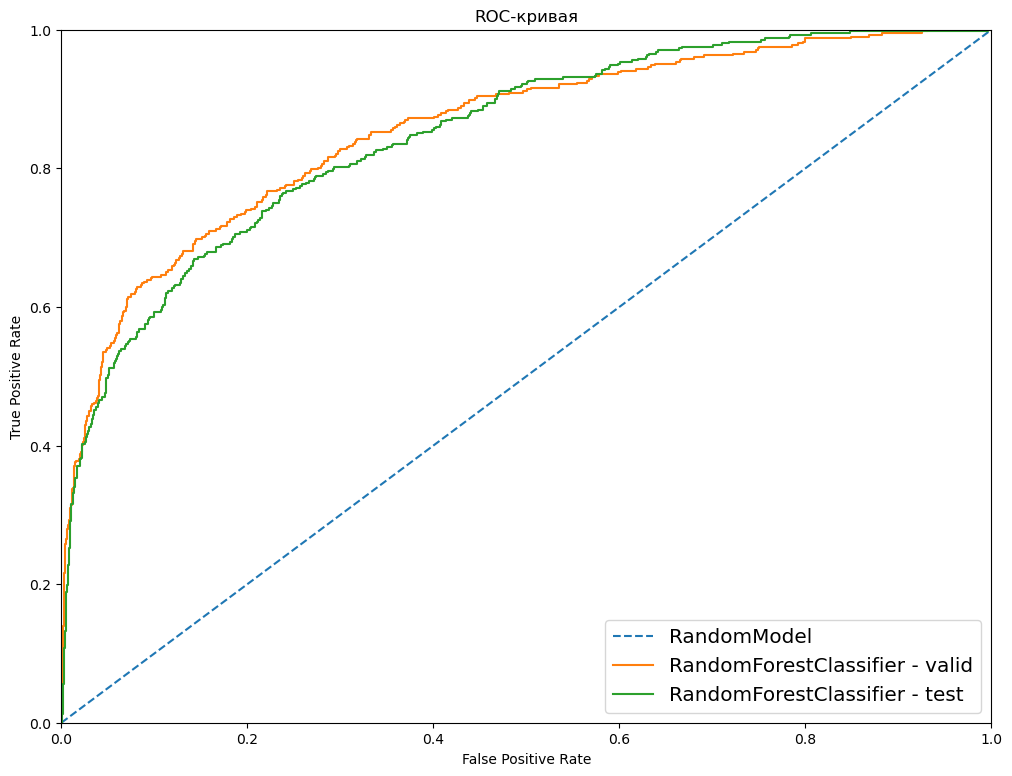

In [36]:
plt.figure(figsize=[12,9])
plt.plot([0, 1], [0, 1], linestyle= '--', label = 'RandomModel')

probabilities_valid = model_RFC.predict_proba(x_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(y_valid, probabilities_one_valid)
auc_roc = roc_auc_score(y_valid, probabilities_one_valid)
print('AUC-ROC RandomForestClassifier - valid', auc_roc)
plt.plot(fpr, tpr, label = 'RandomForestClassifier - valid')

probabilities_test = model_RFC.predict_proba(x_test)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, probabilities_one_test)
auc_roc = roc_auc_score(y_test, probabilities_one_test)
print('AUC-ROC RandomForestClassifier - test', auc_roc)
plt.plot(fpr, tpr, label = 'RandomForestClassifier - test')

plt.xlim([0,1])
plt.ylim([0,1])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend(loc='lower right', fontsize = 'x-large')

plt.title('ROC-кривая')
plt.show()

**Вывод:**

Модель случайного леса с увеличенным количеством класса 1 достигла требуемого значения 0.6456.(> 0.59) F-меры на тестовых данных.

Баланс классов повышает охват необходимых данных, F-мера имеет небольшой прирост.

В результате исследования была получена модель с лучшими показателями как по F1-мере,

так и по AUC-ROC - Случайный лес с увеличенным количеством класса 1.


<a id=7></a>
[Содержание](#0)
## 7. Общий вывод

#### Было выполнено:

- Просмотрена таблица, найдены пропущенные значения.
- Проведена предобработка таблицы: заполнение пропусков, удаление ненужных признаков.
- Проведен анализ по данным и подготовлены актуальные данные.
- Для борьбы с дисбалансом сравнили модели: с взвешенными классами, с уменьшенной выборкой, с увеличенной выборкой.
- Выполнено тестирование модели Случайного леса, построена построена ROC-кривая.

Сотрудникам «Бета-Банка» рекомендуется использовать подготовленную модель Случайного леса с F1 = 0.6456 для прогнозирования возможного ухода клиент из банка в ближайшее время.